In [1]:
import os
import json
import numpy as np
import torch
import result
import pandas as pd
from rnn_model import LSTMNet, GRUNet
from utils import DotDict, Logger, rmse, rmse_tensor, boolean_string, get_dir, get_time, next_dir, model_dir, get_model
from get_dataset import get_time_data, get_stnn_data
from stnn import SaptioTemporalNN
import matplotlib.pyplot as plt
from matplotlib import axis
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
%matplotlib inline


In [2]:
%load_ext autoreload
%autoreload 1
%aimport result

## Data

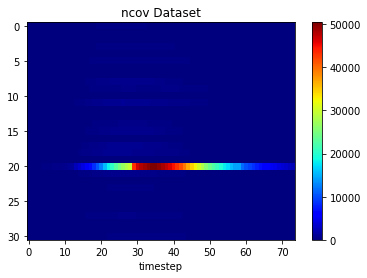

In [3]:
datadir = 'data'
dataset = 'ncov_confirmed'
data = get_time_data(datadir, dataset)

plt.figure('ncov Dataset')
plt.imshow(data.squeeze().numpy().T, aspect='auto', cmap='jet')
plt.title('ncov Dataset')
plt.xlabel('timestep')
plt.colorbar()

## Mode List

In [4]:
folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'output', 'current'))

In [12]:
current = result.Printer(folder)
pd.options.display.max_rows = None
# a = current.get_df(col=['train_loss', 'test_loss', 'mode']).sort_values('test_loss', ascending=True)
current.get_df(col=['train_loss', 'test_loss', 'mode', 'nhid', 'nlayers', 'nz', 'dropout_d', 'simple_dec', 'seq_length', 'rnn_model']).sort_values('test_loss', ascending=True)

input-stnn_revised_17-36-01-04-18  x
ori-stnn_01-47-02-04-03  x
ori-stnn_01-47-02-04-04  x
ori-stnn_01-47-02-04-06  x
ori-stnn_01-47-02-04-07  x
ori-stnn_01-47-02-04-08  x
ori-stnn_01-47-02-04-09  x
revised-stnn_01-25-02-04-54  x
revised-stnn_01-25-02-04-55  x
revised-stnn_01-25-02-04-56  x
revised-stnn_01-25-02-04-58  x
revised-stnn_01-25-02-04-59  x
revised-stnn_01-26-02-04-00  x
rnn_04-33-02-04-48  x
rnn_17-11-01-04-04  x
rnn_17-11-01-04-06  x


,train_loss,test_loss,mode,nhid,nlayers,nz,dropout_d,simple_dec,seq_length,rnn_model
ori-stnn_18-48-01-04-19,0.111,0.0446943,None,100,2,10,0.5,NaN,NaN,NaN
ori-stnn_22-04-01-04-12,0.0942005,0.0458592,None,100,2,10,0.5,NaN,NaN,NaN
input-stnn_01-11-04-04-17,0.20695,0.0490449,discover,20,4,10,0.9,False,NaN,NaN
input-stnn_01-25-04-04-35,0.00174829,0.0503315,discover,20,2,10,0.5,True,NaN,NaN
input-stnn_23-49-01-04-08,0.0113367,0.0505001,None,200,4,20,0.5,NaN,NaN,NaN
ori-stnn_19-02-01-04-40,0.105416,0.0535651,refine,100,2,10,0.5,NaN,NaN,NaN
input-stnn_01-18-04-04-37,0.00166228,0.054283,refine,20,2,10,0.5,True,NaN,NaN
ori-stnn_22-42-01-04-59,0.272756,0.0546985,discover,100,2,10,0.5,NaN,NaN,NaN
input-stnn_01-17-04-04-30,0.00146561,0.0584118,None,20,2,10,0.5,True,NaN,NaN
concat-stnn_22-53-03-04-44,0.00110063,0.061119,discover,200,4,10,0.5,True,NaN,NaN


## Exp 

In [10]:
exp_dir = {}
exp_dir['stnn'] = 'ori-stnn_17-02-02-04-03'
exp_dir['stnn-r'] = 'ori-stnn_19-02-01-04-40'
exp_dir['stnn-d'] = 'ori-stnn_22-42-01-04-59'
exp_dir['input_stnn'] = 'input-stnn_23-49-01-04-08'
exp_dir['input_stnn-r'] = 'input-stnn_01-18-04-04-37'
exp_dir['input_stnn-d'] = 'input-stnn_01-11-04-04-17'
exp_dir['concat_stnn'] = 'concat-stnn_22-48-01-04-14'
exp_dir['concat_stnn-r'] = 'concat-stnn_23-18-01-04-33'
exp_dir['concat_stnn-d'] = 'concat-stnn_21-56-01-04-16'
exp_dir['LSTM'] = 'keras-rnn_22-34-03-04-24'
exp_dir['GRU'] = 'keras-rnn_14-38-03-04-13'
exp = {}
pred = {}
for k, v in exp_dir.items():
    exp[k] = result.Exp(v, folder)
    pred[k] = exp[k].pred().numpy().T

d:\Jupyter_Documents\ML-code\research_code\output\current
ori-stnn_18-54-02-04-52
config.json
logs.json
model.pt
true_pred_000.txt
d:\Jupyter_Documents\ML-code\research_code\output\current
ori-stnn_19-02-01-04-40
config.json
logs.json
model.pt
true_pred_000.txt
d:\Jupyter_Documents\ML-code\research_code\output\current
ori-stnn_22-42-01-04-59
config.json
logs.json
model.pt
true_pred_000.txt
d:\Jupyter_Documents\ML-code\research_code\output\current
input-stnn_23-49-01-04-08
config.json
logs.json
model.pt
true_pred_000.txt
d:\Jupyter_Documents\ML-code\research_code\output\current
input-stnn_01-18-04-04-37
config.json
logs.json
model.pt
true_pred_000.txt
d:\Jupyter_Documents\ML-code\research_code\output\current
input-stnn_01-11-04-04-17
config.json
logs.json
model.pt
true_pred_000.txt
d:\Jupyter_Documents\ML-code\research_code\output\current
concat-stnn_22-48-01-04-14
config.json
logs.json
model.pt
true_pred_000.txt
d:\Jupyter_Documents\ML-code\research_code\output\current
concat-stnn_23-1

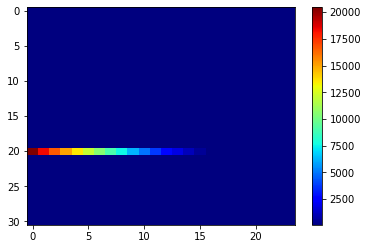

In [17]:
plt.figure()
plt.imshow(pred['stnn'], aspect='auto', cmap='jet')
plt.colorbar()

In [18]:
test_data = data[-pred['stnn'].shape[1]:].squeeze().numpy().T
test_data.shape

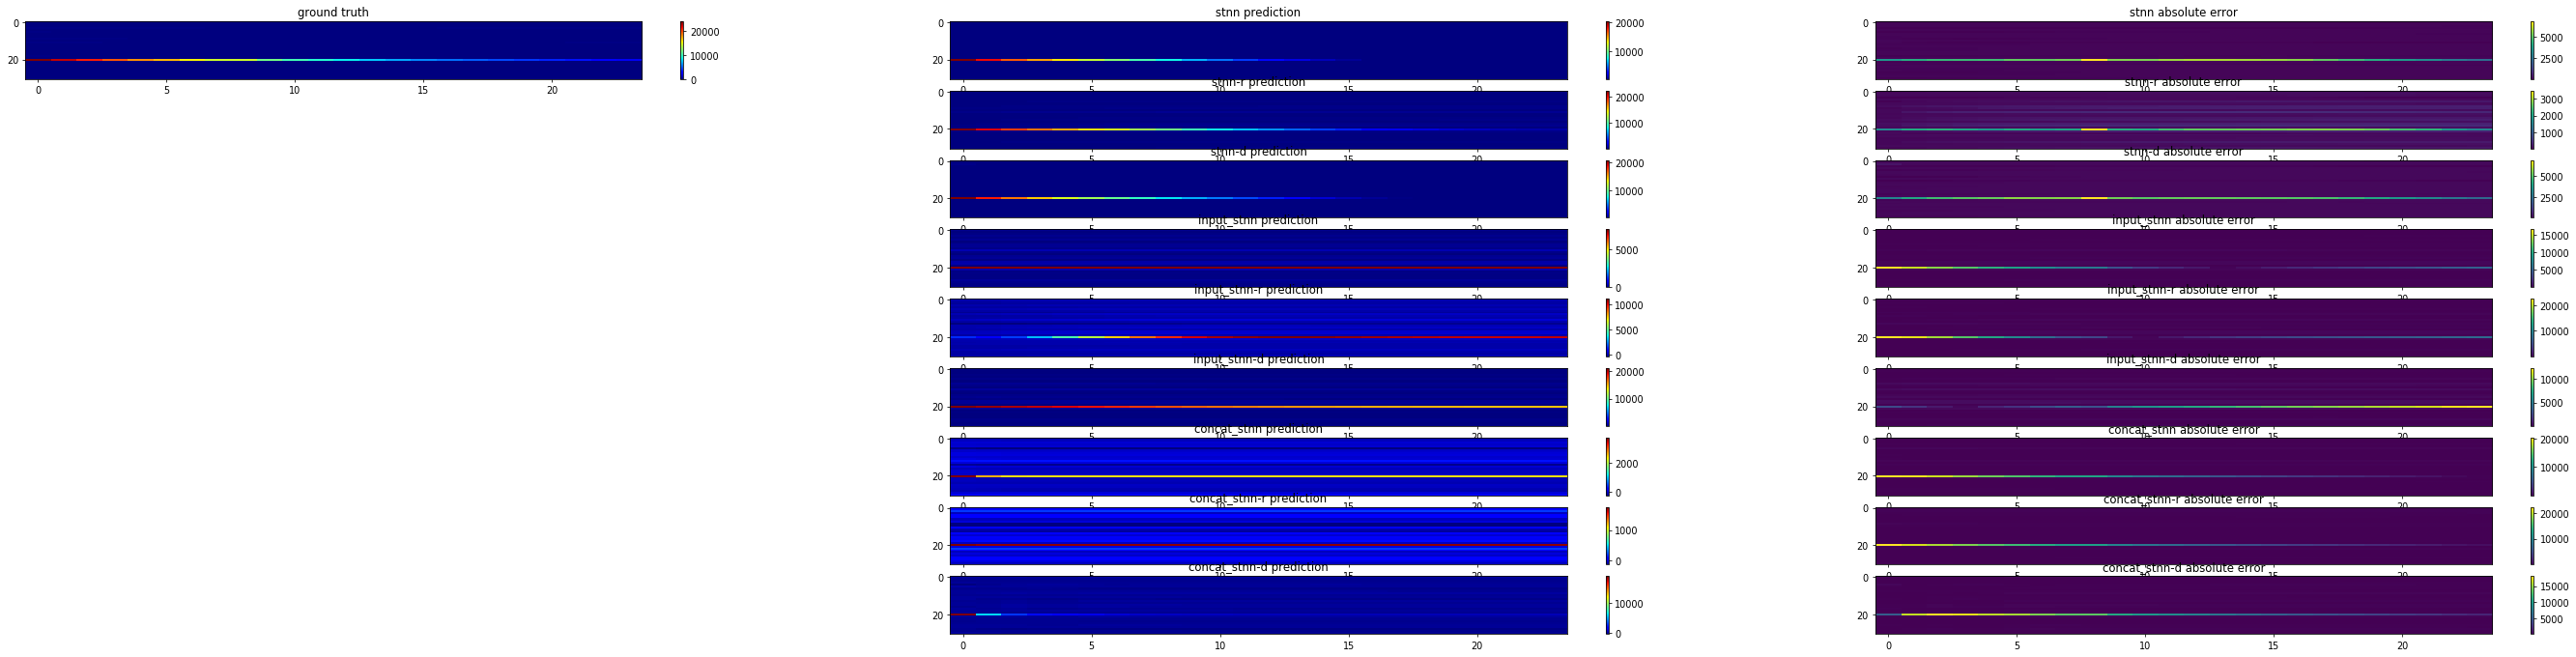

In [25]:
plt.figure('Results', figsize=(17, 12), dpi=70)

plt.subplot(9, 3, 1)
plt.imshow(test_data, aspect='auto', cmap='jet')
plt.colorbar()
plt.title('ground truth')

for i, exp in enumerate(pred):
    plt.subplot(9, 3, i * 3 + 2)
    plt.imshow(pred[exp], aspect='auto', cmap='jet')
    plt.colorbar()
    plt.title('{} prediction'.format(exp))

    plt.subplot(9, 3, i * 3 + 3)
    plt.imshow(np.abs(test_data - pred[exp]), aspect='auto')
    plt.colorbar()
    plt.title('{} absolute error'.format(exp))

## Aids LSTM

In [8]:
folder_name = 'aids_LSTM'
model_name = get_model(folder_name)[1]
model_list = model_dir[folder_name]

### The Best Model 

In [ ]:
for model in model_list:
    model = LSTMNet()

In [5]:
outputdir = 'output'
exps = ['stnn']
models = {}
for exp in exps:
    with open(os.path.join(outputdir, exp, 'config.json'), 'r') as f:
        config = json.load(f)
    setup, (train_input, train_output), (test_input, test_data)  = dataset_factory(datadir, dataset, 700, 5)
    model = rnn(29, config['nhid'], config['nlayers'], 29, config['seq_length'])
    state_dict = torch.load(os.path.join(outputdir, exp, 'model.pt'), map_location=lambda storage, loc: storage)
    model.load_state_dict(state_dict)
    models[exp] = model

## Results

In [6]:
predictions = {}
for exp in exps:
    model = models[exp]
    model.eval()
    with torch.no_grad():
        prediction = model.generate(test_input, 396)
        predictions[exp] = prediction
        mse =  rmse(prediction, test_data)
        print(prediction.size())
    print('RMSE {}:\t'.format(exp), mse)

torch.Size([396, 29, 1])
RMSE stnn:	 9.350045204162598


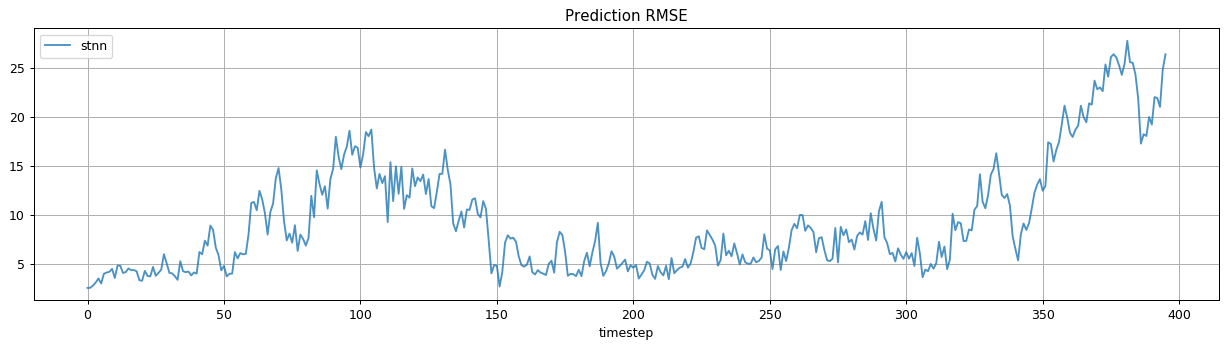

In [7]:
plt.figure('Test plots', figsize=(17, 4), dpi=90)
for exp in exps:
    with open(os.path.join(outputdir, exp, 'logs.json'), 'r') as f:
        logs = json.load(f)

    plt.plot([logs['test_epoch.ts.{}.rmse'.format(ts)][-1] for ts in range(396)], label=exp, alpha=0.8)

plt.grid()
plt.title('Prediction RMSE')
plt.xlabel('timestep')
plt.legend()

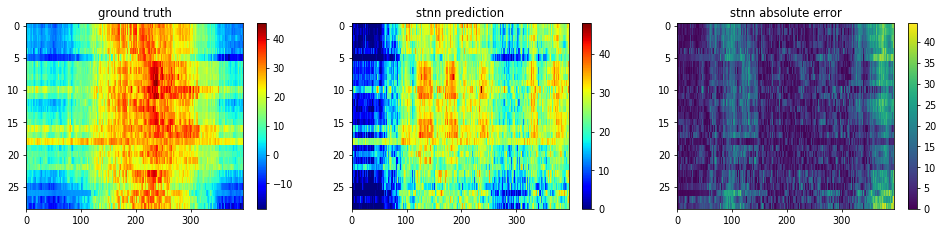

In [8]:
plt.figure('Results', figsize=(17, 12), dpi=70)

plt.subplot(3, 3, 1)
plt.imshow(test_data.squeeze().numpy().T, aspect='auto', cmap='jet')
plt.colorbar()
plt.title('ground truth')

for i, exp in enumerate(exps):
    plt.subplot(3, 3, i * 3 + 2 + i // 3)
    plt.imshow(predictions[exp].squeeze().numpy().T, aspect='auto', cmap='jet')
    plt.colorbar()
    plt.title('{} prediction'.format(exp))

    plt.subplot(3, 3, i * 3 + 3 + i // 3)
    plt.imshow(test_data.sub(predictions[exp]).abs().squeeze().numpy().T, aspect='auto')
    plt.colorbar()
    plt.title('{} absolute error'.format(exp))